# Frederick

---
**Virtual AI Assistant for University of Naples Federico II**

<center><img src="https://upload.wikimedia.org/wikipedia/commons/5/5c/University_Federico_II_Logo.svg" alt="UNINA Logo" height=200px width=200px></center>

*Text Mining Course Project* <br> by **Mohammad Solki**

*A.Y. 2023/24*

In [1]:
#@title Install necessary libraries
!pip install langchain_community pandas huggingface_hub chromadb==0.4.14 langchain-huggingface langchain_groq lark openai gradio python-dotenv qrcode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 448.1/448.1 kB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.5/325.5 kB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 63.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 71.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 77.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 80.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Define Constant Variables

In [3]:
#@title Get API Keys from environment variables
def get_key(key,required=True):
    try:
        from google.colab.userdata import get as getenv
    except ImportError:
        from os import getenv
        import dotenv
        dotenv.load_dotenv()

    value = getenv(key)

    if not value:
        value = input(f"Please enter the value for {key}:")
        if value == "" and required:
            raise ValueError(f"Value for {key} is required")

    return value

In [4]:
#@title Set tokens, keys, and default directories
# Tokens and API Keys
huggingface_token = get_key("HUGGINGFACE_KEY")
groq_api_key = get_key("GROQ_KEY")

# Directories
DATA_DIR = './data'
persist_directory = DATA_DIR+"/chroma_db"
embedding_cache_directory = DATA_DIR+"/embedding_cache"
USER_AGENT="Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 YaBrowser/24.4.0.0 Safari/537.36"

In [5]:
from huggingface_hub import login
login(token=huggingface_token)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful


---

## RAG Pipeline


<center><img src="https://i.ibb.co/jzwRBTN/Screenshot-2024-06-18-at-10-12-50.png" alt="RAG-Pipeline" border="0">

## Load the necessary documents

In this step we will import the documents from the datasets prepared by the scraper. Including:
* List of university courses (csv)
* Description and necessary information of each course (json, csv)

Also:
* The system message for the chatbot (txt)
* General university information (web)

In [6]:
import pandas as pd

course_list_df = pd.read_json(DATA_DIR + '/courses_list.json')
course_desc_df = pd.read_json(DATA_DIR + '/courses_description_legacy.json')


def get_course_unit_content(course_unit):
    content = f"""
    The course with code {course_unit['Code']}, named "{course_unit['Name']}" (English name: "{course_unit['English name']}"), is coordinated by {course_unit['Coordinator']}. It is part of the {course_unit['Course type']} program in the {course_unit['Department']} department under the {course_unit['School']} school. The course is conducted in {course_unit['Language']} and is located in {course_unit['Locations']}. This course was activated in the year {course_unit['Activation year']}. For more information, visit the course homepage: {course_unit['Course Homepage']}.
    """
    return content.strip()

# def rename_columns(df, target_column_name, new_name):
#     return df.rename(columns={target_column_name: new_name})

def load_courses_document_df(course_desc_df):
    course_desc_df['content'] = course_desc_df.apply(lambda x: get_course_unit_content(x), axis=1)
    metadata = ["Code", "Name", "English name", "Phased out", "Coordinator",
                "Contacts", "Course type", "Duration", "Language",
                "Degree class", "Activation year", "School", "Department",
                "Locations", "Course Homepage", "content"]

    return course_desc_df[metadata]

df = load_courses_document_df(course_desc_df)
df['Contacts'] = df['Contacts'].astype(str)
df

,Code,Name,English name,Phased out,Coordinator,Contacts,Course type,Duration,Language,Degree class,Activation year,School,Department,Locations,Course Homepage,content
0,N70,ARCHEOLOGIA E STORIA DELL'ARTE,ARCHAEOLOGY AND HISTORY OF ART,No,DI MEGLIO ROSALBA,rosalba.dimeglio@unina.it,Laurea Magistrale,2 anni,Italian,LM-2 - Classe delle lauree magistrali in Arche...,2008,SCUOLA DELLE SCIENZE UMANE E SOCIALI,DIPARTIMENTO DI STUDI UMANISTICI,NAPOLI,https://www.corsi.unina.it/N70,"The course with code N70, named ""ARCHEOLOGIA E..."
1,P14,"ARCHEOLOGIA, STORIA DELLE ARTI E SCIENZE DEL P...","ARCHEOLOGY, HISTORY OF ARTS AND SCIENCE OF ART...",No,CICALA LUIGI,luigi.cicala@unina.it,Laurea,3 anni,Italian,L-1 - Classe delle lauree in Beni culturali,2015,SCUOLA DELLE SCIENZE UMANE E SOCIALI,DIPARTIMENTO DI STUDI UMANISTICI,NAPOLI,https://www.corsi.unina.it/P14,"The course with code P14, named ""ARCHEOLOGIA, ..."
2,P53,ARCHITECTURE AND HERITAGE,ARCHITECTURE AND HERITAGE,No,PANE ANDREA,andrea.pane@unina.it,Laurea Magistrale,2 anni,English,LM-4 - Classe delle lauree magistrali in Archi...,2021,SCUOLA POLITECNICA E DELLE SCIENZE DI BASE,DIPARTIMENTO DI ARCHITETTURA,NAPOLI,https://www.corsi.unina.it/P53,"The course with code P53, named ""ARCHITECTURE ..."
3,D06,ARCHITETTURA,Not indicated,No,CERRETA MARIA,maria.cerreta@unina.it,Laurea Magistrale Ciclo Unico 5 anni,5 anni,Italian,LM-4 c.u. - Classe delle lauree magistrali in ...,2023,SCUOLA POLITECNICA E DELLE SCIENZE DI BASE,DIPARTIMENTO DI ARCHITETTURA,NAPOLI,https://www.corsi.unina.it/D06,"The course with code D06, named ""ARCHITETTURA""..."
4,N14,ARCHITETTURA,ARCHITECTURE,Yes,CERRETA MARIA,maria.cerreta@unina.it,Laurea Magistrale Ciclo Unico 5 anni,5 anni,Italian,LM-4 c.u. - Classe delle lauree magistrali in ...,2008,SCUOLA POLITECNICA E DELLE SCIENZE DI BASE,DIPARTIMENTO DI ARCHITETTURA,NAPOLI,https://www.corsi.unina.it/N14,"The course with code N14, named ""ARCHITETTURA""..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,N10,TECNOLOGIE ALIMENTARI,FOOD TECHNOLOGY,No,FERRANTI PASQUALE,pasquale.ferranti@unina.it,Laurea,3 anni,Italian,L-26 - Classe delle lauree in Scienze e tecnol...,2008,SCUOLA DI AGRARIA E MEDICINA VETERINARIA,DIPARTIMENTO DI AGRARIA,Federico II - Portici,https://www.corsi.unina.it/N10,"The course with code N10, named ""TECNOLOGIE AL..."
183,N72,TECNOLOGIE DELLE PRODUZIONI ANIMALI,Technologies in animal productions,Yes,CALABRO' SERENA,serena.calabro@unina.it,Laurea,3 anni,Italian,L-38 - Classe delle lauree in Scienze zootecni...,2008,SCUOLA DI AGRARIA E MEDICINA VETERINARIA,DIPARTIMENTO DI MEDICINA VETERINARIA E PRODUZI...,Dipartimento Medicina Veterinaria e Produzioni...,https://www.corsi.unina.it/N72,"The course with code N72, named ""TECNOLOGIE DE..."
184,P22,TOSSICOLOGIA CHIMICA E AMBIENTALE,CHEMISTRY AND ENVIROMENTAL TOXICOLOGY,No,SORRENTINO RAFFAELLA,raffaella.sorrentino@unina.it,Laurea Magistrale,2 anni,Italian,LM-75 - Classe delle lauree magistrali in Scie...,2014,SCUOLA DI MEDICINA E CHIRURGIA,DIPARTIMENTO DI FARMACIA,NAPOLI,https://www.corsi.unina.it/P22,"The course with code P22, named ""TOSSICOLOGIA ..."
185,P55,TRANSPORTATION ENGINEERING AND MOBILITY,TRANSPORTATION ENGINEERING AND MOBILITY,No,BIFULCO GENNARO NICOLA,gennaronicola.bifulco@unina.it,Laurea Magistrale,2 anni,English,LM-23 - Classe delle lauree magistrali in Inge...,2021,SCUOLA POLITECNICA E DELLE SCIENZE DI BASE,"DIPARTIMENTO DI INGEGNERIA CIVILE, EDILE E AMB...",NAPOLI,https://www.corsi.unina.it/P55,"The course with code P55, named ""TRANSPORTATIO..."


In [7]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.document_loaders import TextLoader
from langchain_community.document_loaders.merge import MergedDataLoader
from langchain_community.document_loaders.dataframe import DataFrameLoader
import bs4

# Define system message and metadata documents
system_message = TextLoader(DATA_DIR + '/system_message.txt')

desc_metadata = TextLoader(DATA_DIR + '/description_metadata.txt')

# Let's load help desk and other services
webDocs = WebBaseLoader(
    ['https://www.international.unina.it/welcome-desk/'],
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_="post-2026 page type-page status-publish ast-article-single"
        )
    ),
)

# Let's load the course list and details documents
# course_list_df = DataFrameLoader(load_courses_document_df(course_desc_df), 'content')
course_desc_df = DataFrameLoader(df, 'content')

# Merge all the available documents
merged_loader = MergedDataLoader([system_message, webDocs, course_desc_df, desc_metadata])
documents = merged_loader.load()

print(f'There are {len(documents)} pages in total')

There are 190 pages in total


In [9]:
#@title Retreive a random document
import random

random_index = random.randint(0, len(documents))
document_content = documents[random_index].page_content
document_metadata = documents[random_index].metadata
print(document_content,"\n---\n",document_metadata)

The course with code P09, named "ECONOMICS AND FINANCE" (English name: "ECONOMICS AND FINANCE"), is coordinated by SIMONELLI SAVERIO. It is part of the Laurea Magistrale program in the DIPARTIMENTO DI SCIENZE ECONOMICHE E STATISTICHE department under the SCUOLA DELLE SCIENZE UMANE E SOCIALI school. The course is conducted in English and is located in NAPOLI. This course was activated in the year Activation year. For more information, visit the course homepage: https://www.corsi.unina.it/P09. 
---
 {'Code': 'P09', 'Name': 'ECONOMICS AND FINANCE', 'English name': 'ECONOMICS AND FINANCE', 'Phased out': 'No', 'Coordinator': 'SIMONELLI SAVERIO', 'Contacts': 'saverio.simonelli@unina.it', 'Course type': 'Laurea Magistrale', 'Duration': '2 anni', 'Language': 'English', 'Degree class': "LM-56 - Classe delle lauree magistrali in Scienze dell'economia", 'Activation year': 'Activation year', 'School': 'SCUOLA DELLE SCIENZE UMANE E SOCIALI', 'Department': 'DIPARTIMENTO DI SCIENZE ECONOMICHE E STATI

## Efficient Document Processing through Segmentation

By breaking down large documents into smaller, more manageable chunks, we can streamline our processing efforts and achieve greater efficiency. This process, known as text segmentation or splitting, involves dividing a massive document into distinct, bite-sized pieces. By doing so, we can analyze and process the text in a more detailed and structured manner, enabling us to extract valuable insights and information from the data.

While segmenting documents may potentially disrupt the original context or meaning of the text, we can employ various techniques to mitigate this issue. For instance, we can utilize recursive splitting methods or incorporate techniques that preserve the original context and meaning of the text.

In [10]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=250,
    separators=["\n\n", "\n", " ", ""]
)

texts = text_splitter.split_documents(documents)

print(f'We have created {len(texts)} chunks from {len(documents)} pages')

We have created 191 chunks from 190 pages


## Vector Representation Using Embedding Models

When converting text into numerical representations, we rely on various embedding models to transform the text into dense vectors that capture its semantic meaning. Popular options include BERT, RoBERTa, GPT-2, among others. In this example, we utilize the MiniLM model, a smaller variant of the BERT architecture. By applying an embedding model, we can convert text into numerical vectors that encode the semantic essence of the text. These vectors can be employed for various natural language processing tasks, such as:

* Text classification: categorizing text based on its content
* Clustering: grouping similar texts together
* Similarity search: identifying the most relevant texts based on their semantic meaning

The embedding model plays a crucial role in enabling these NLP applications by providing a compact and meaningful representation of the original text.


In [11]:
from langchain_huggingface import HuggingFaceEmbeddings

embedding_model = HuggingFaceEmbeddings(model_name='all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### Efficient Embedding Retrieval Using Caching

When processing new documents, our approach first checks the cache for pre-computed embeddings. If these embeddings are not readily available, the method employs an underlying embedder to generate the embeddings and stores them in the cache for future reference.

By leveraging caching, we can:

* Avoid recalculating embeddings each time, which can be computationally expensive
* Retrieve embeddings from memory, making our process faster and more efficient

To optimize our embedding-based workflow, let's set up a cache to store pre-computed embeddings. This will enable us to quickly retrieve relevant
information and reduce the computational overhead associated with re-calculating embeddings.


In [12]:
from langchain.storage import LocalFileStore
from langchain.embeddings import CacheBackedEmbeddings

store = LocalFileStore(embedding_cache_directory)
embedding_model = CacheBackedEmbeddings.from_bytes_store(embedding_model, store)

### Vector Database for Efficient Storage and Retrieval

Vector databases are designed to efficiently store and retrieve vectors, making them an essential component in applications such as information retrieval, recommendation systems, and clustering. These databases enable fast similarity searches by comparing query vectors with stored vectors, allowing us to quickly identify the most relevant matches.

In this notebook, we utilize the Chroma vector database, which is optimized for tasks involving similarity search and retrieval.

**Important Note**: Due to the relatively small size of our documents, it's more efficient to pass entire documents to the vector database at once, rather than splitting them. This approach simplifies the process and minimizes potential errors.

After the initial vectorization step, we load pre-computed vectors from cache on subsequent calls, ensuring a seamless and optimized experience for future interactions with the vector database.


In [13]:
import os
from langchain_community.vectorstores import Chroma


# Check if persist_directory exists or not
if os.path.exists(persist_directory):
    # Read from cache
    vectordb = Chroma(
        persist_directory= persist_directory ,
        embedding_function=embedding_model
    )
else:
    # Vectorize documents without splitting
    vectordb = Chroma.from_documents(
        documents=documents,
        embedding=embedding_model,
        persist_directory=persist_directory
    )

Let's assess the similarity between the retrieved documents and the original query:


In [14]:
result = vectordb.similarity_search(
    'Who is the person in charge for autonomous vehicle engineering course?',
    #k=6
)

print(f"for query {len(result)} results found")
print(result[0].page_content)
print(result[0].metadata)

for query 4 results found
The course with code D18, named "AUTONOMOUS VEHICLE ENGINEERING" (English name: "AUTONOMOUS VEHICLE ENGINEERING"), is coordinated by PATALANO STANISLAO. It is part of the Laurea Magistrale program in the DIPARTIMENTO DI INGEGNERIA INDUSTRIALE department under the SCUOLA POLITECNICA E DELLE SCIENZE DI BASE school. The course is conducted in English and is located in NAPOLI. This course was activated in the year 2023. For more information, visit the course homepage: https://www.corsi.unina.it/D18.
{'Activation year': '2023', 'Code': 'D18', 'Contacts': 'stanislao.patalano@unina.it', 'Coordinator': 'PATALANO STANISLAO', 'Course Homepage': 'https://www.corsi.unina.it/D18', 'Course type': 'Laurea Magistrale', 'Degree class': 'LM-33 - Classe delle lauree magistrali in Ingegneria meccanica', 'Department': 'DIPARTIMENTO DI INGEGNERIA INDUSTRIALE', 'Duration': '2 anni', 'English name': 'AUTONOMOUS VEHICLE ENGINEERING', 'Language': 'English', 'Locations': 'NAPOLI', 'Name

In [15]:

result = vectordb.similarity_search(
    'Artificial Intelligence',
    # k=6
)
print(f"for query {len(result)} results found")
print(result[0].page_content)
print(result[0].metadata)

for query 4 results found
The course with code P38, named "INGEGNERIA DELL'AUTOMAZIONE E ROBOTICA" (English name: "AUTOMATION ENGINEERING AND ROBOTICS"), is coordinated by DE TOMMASI GIANMARIA. It is part of the Laurea Magistrale program in the DIPARTIMENTO DI INGEGNERIA ELETTRICA E TECNOLOGIE DELL'INFORMAZIONE department under the SCUOLA POLITECNICA E DELLE SCIENZE DI BASE school. The course is conducted in Italian and is located in NAPOLI. This course was activated in the year 2019. For more information, visit the course homepage: https://www.corsi.unina.it/P38.
{'Activation year': '2019', 'Code': 'P38', 'Contacts': 'gianmaria.detommasi@unina.it', 'Coordinator': 'DE TOMMASI GIANMARIA', 'Course Homepage': 'https://www.corsi.unina.it/P38', 'Course type': 'Laurea Magistrale', 'Degree class': "LM-25 - Classe delle lauree magistrali in Ingegneria dell'automazione", 'Department': "DIPARTIMENTO DI INGEGNERIA ELETTRICA E TECNOLOGIE DELL'INFORMAZIONE", 'Duration': '2 anni', 'English name': 'A

### Utilizing the LLM with Groq API

To leverage the power of language models, let's load the LLaMA model using the Groq API. This will enable us to tap into the capabilities of this
pre-trained model without having to fine-tune it for our specific task. By utilizing the Groq API, we can streamline our workflow and optimize
performance.

In particular, I plan to utilize the `nvidia/Llama3-ChatQA-1.5-8B` model from Hugging Face's model hub. This model has been specifically designed for
chat-style question answering tasks and is expected to provide strong performance in this domain.


In [16]:
from langchain_groq import ChatGroq
chat_model = ChatGroq(temperature=0, groq_api_key=groq_api_key, model_name="llama3-8b-8192")

#### Evaluating Model Performance on Unseen Questions

Now, let's put the model to the test by asking it questions and assessing its ability to provide accurate answers. Since we're working with an unseen dataset, this exercise will help us gauge the model's generalizability and ability to generalize beyond its training data.


In [17]:
qa_result = chat_model.invoke(
    "Who is the person in charge for autonomous vehicle engineering course in University of Naples Federico II?"
)
print(qa_result.content)

I've searched for the University of Naples Federico II's Autonomous Vehicle Engineering course, but I couldn't find a specific person in charge for the course. The university's website doesn't provide a single point of contact for the course.

However, I can suggest some alternatives to help you find the contact information:

1. **Department of Engineering**: The Autonomous Vehicle Engineering course is likely part of the Department of Engineering at the University of Naples Federico II. You can visit the department's website and look for the contact information of the department's director or the person in charge of the course.
2. **Faculty of Engineering**: Another option is to contact the Faculty of Engineering at the University of Naples Federico II. They may be able to provide you with the contact information of the person in charge of the Autonomous Vehicle Engineering course.
3. **Contact the University's International Office**: The University of Naples Federico II has an Intern

### Contextual Compression: A Technique for Enhanced Retrieval

**NOTE: This method is not used in the final implementation.**

In this implementation, we utilize contextual compression as a technique to condense the context surrounding a query into a more compact representation. This compressed context is then used to retrieve relevant information from our vector database.

By passing the compressed context to our retrieval model, we enable it to pinpoint the most pertinent documents or vectors with greater accuracy. This approach has the added benefit of reducing the search space, allowing us to focus on the most promising candidates and ultimately improving the overall retrieval process.


In [18]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor

compressor = LLMChainExtractor.from_llm(chat_model)
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor,
    base_retriever=vectordb.as_retriever()
)

In [19]:
results = compression_retriever.invoke(
    "Who is the person in charge for autonomous vehicle engineering course?")
result[0]

Document(page_content='The course with code P38, named "INGEGNERIA DELL\'AUTOMAZIONE E ROBOTICA" (English name: "AUTOMATION ENGINEERING AND ROBOTICS"), is coordinated by DE TOMMASI GIANMARIA. It is part of the Laurea Magistrale program in the DIPARTIMENTO DI INGEGNERIA ELETTRICA E TECNOLOGIE DELL\'INFORMAZIONE department under the SCUOLA POLITECNICA E DELLE SCIENZE DI BASE school. The course is conducted in Italian and is located in NAPOLI. This course was activated in the year 2019. For more information, visit the course homepage: https://www.corsi.unina.it/P38.', metadata={'Activation year': '2019', 'Code': 'P38', 'Contacts': 'gianmaria.detommasi@unina.it', 'Coordinator': 'DE TOMMASI GIANMARIA', 'Course Homepage': 'https://www.corsi.unina.it/P38', 'Course type': 'Laurea Magistrale', 'Degree class': "LM-25 - Classe delle lauree magistrali in Ingegneria dell'automazione", 'Department': "DIPARTIMENTO DI INGEGNERIA ELETTRICA E TECNOLOGIE DELL'INFORMAZIONE", 'Duration': '2 anni', 'English

## Crafting Effective Prompt Templates for LLM Models

**NOTE:** Below text was generated by LLaMA.

To elicit the best possible responses from our LLM models, we'll follow these guidelines to create high-quality prompt templates.

* Ensure that your prompts are concise and easy to understand, avoiding technical jargon and using natural language instead.
* To provide additional context, ask the LLM to role-play as a character with a specific goal. For example, "You are a marketing executive who wants to invite major customers to a live event."
* Refine your prompt templates by iterating on different approaches to achieve the same goal. Seek feedback from end-users and analyze how well your prompts generate desired responses.
* Consistency is key: choose a writing style and stick to it, using consistent word choice, intensifiers, emojis, and punctuation to shape the LLM's
response.
* To help the LLM differentiate between context and instructions, create an "Instructions" section with triple quotes (""") in your prompt template.
This will guide the model to focus on generating specific content rather than discussing the process.
* Include direct instructions for the LLM to generate only the expected type of content. For example, if you want a draft email, specify that the
response should strictly follow these guidelines.

To get started, draw inspiration from the Example Prompt Template Library and customize templates to fit your unique needs. Study the language used
in the examples, paying particular attention to writing style and phrasing. You can apply similar techniques to create effective prompt templates for
your LLM models.


In [20]:
from langchain.prompts import SystemMessagePromptTemplate, PromptTemplate, HumanMessagePromptTemplate, MessagesPlaceholder, ChatPromptTemplate


qa_system_prompt_template = """
As Frederick, your mission is to assist students in finding relevant information about courses, degrees, services, and general university details. To answer questions accurately, please rely on the following guidelines.

* When answering, use the provided context to provide the most accurate response possible.
* If you're unsure or don't know the answer based on the available information, simply state "I don't know" instead of attempting to fabricate an answer.

Additionally, follow these specific rules:
1. Link-only responses: If a question requests links, only return the source links without providing an answer.
2. Unknown answers: When you can't find the final answer based on available information, provide a clear indication by saying "I can't find the final answer but you may want to check the following links" and include the relevant source links as a list.
3. Answer and sources: If you do find the answer, present it in a concise manner and accompany it with a list of sources that were directly used to derive the answer. Exclude any sources that are not directly related to the final answer.

{context}"""

qa_system_prompt = SystemMessagePromptTemplate(
    prompt=PromptTemplate(
        input_variables=["context"], template=qa_system_prompt_template
    )
)

qa_human_prompt_template = """Question: {input}
Answer:"""

qa_human_prompt = HumanMessagePromptTemplate(
    prompt=PromptTemplate(input_variables=["question"], template=qa_human_prompt_template)
)

qa_prompt = ChatPromptTemplate.from_messages(
    [
        qa_system_prompt,
        MessagesPlaceholder("chat_history"),
        qa_human_prompt,
    ]
)

### Crafting Contextualized Prompt Templates

When formulating prompt templates for our chatbot, we'll consider two key factors: the chat history and the latest user question. This context might be referenced in the chat history, but we need to create a standalone question that can be understood without it.

Our goal is not to answer the question, but rather to reformulate it if necessary, or return it as is if it's already suitable for our chatbot.


In [21]:

contextualize_system_prompt = (
    "Given a chat history and the latest user question "
    "which might reference context in the chat history, "
    "formulate a standalone question which can be understood "
    "without the chat history. Do NOT answer the question, "
    "just reformulate it if needed and otherwise return it as is."
)

qa_system_prompt =  SystemMessagePromptTemplate.from_template(
    contextualize_system_prompt
)

qa_human_prompt_template = """Question: {input}
Answer:"""

qa_human_prompt = HumanMessagePromptTemplate(
    prompt=PromptTemplate(input_variables=["question"], template=qa_human_prompt_template)
)

contextualize_q_prompt = ChatPromptTemplate.from_messages(
    [
        qa_system_prompt,
        MessagesPlaceholder("chat_history"),
        qa_human_prompt,
    ]
)


### Establishing a Chain of Thought

#### Similarity-Based Search

In the realm of data retrieval from vector databases, the "similarity" search type focuses on identifying documents or vectors that closely match a given query. This approach relies on mathematical metrics like cosine similarity or Euclidean distance to calculate the similarity between the query vector and those stored in the database. Documents with higher similarity scores are deemed more relevant and are returned as search results. The "similarity" search type is commonly employed for tasks such as document retrieval, recommendation systems, and information retrieval.

#### Similarity Score Threshold

The "similarity_score_threshold" search type refines the basic similarity search method by introducing a threshold value to filter out search results based on their similarity scores. Only documents or vectors with similarity scores exceeding the specified threshold are returned as search results.
By setting an appropriate threshold, users can control the level of relevance and precision in the retrieved results. This search type is particularly useful in scenarios where a certain level of similarity is required for result inclusion, such as in content recommendation systems or search engines.

#### Maximal Marginal Relevance (MMR)

Maximal Marginal Relevance (MMR) is a search type that prioritizes diversifying search results by balancing relevance and diversity. Unlike
traditional similarity-based approaches that focus solely on high-similarity scores, MMR considers both the relevance of a document to the query and
its dissimilarity to already retrieved documents. This approach aims to provide a diverse set of search results that cover a wide range of relevant
topics or perspectives, making it particularly useful in tasks like information retrieval, summarization, and recommendation systems where diversity
in results is desired.

In [22]:
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains.history_aware_retriever import create_history_aware_retriever
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain.chains import (create_retrieval_chain)
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.runnables import ConfigurableFieldSpec

retriever = vectordb.as_retriever(
    search_type="similarity",
    search_kwargs={'k': 4}
)

history_aware_retriever = create_history_aware_retriever(chat_model, retriever, contextualize_q_prompt)
question_answer_chain = create_stuff_documents_chain(chat_model, qa_prompt)
rag_chain = create_retrieval_chain(history_aware_retriever, question_answer_chain)


# Store chat history to manage session history
store = {}

def get_session_history(user_id: str, conversation_id: str) -> BaseChatMessageHistory:
    if user_id not in store:
        store[user_id] = ChatMessageHistory()
    return store[user_id]


conversational_rag_chain = RunnableWithMessageHistory(
    rag_chain,
    get_session_history,
    input_messages_key="input",
    history_messages_key="chat_history",
    output_messages_key="answer",
    history_factory_config=[
        ConfigurableFieldSpec(
            id="user_id",
            annotation=str,
            name="User ID",
            description="Unique identifier for the user.",
            default="",
            is_shared=True,
        ),
        ConfigurableFieldSpec(
            id="conversation_id",
            annotation=str,
            name="Conversation ID",
            description="Unique identifier for the conversation.",
            default="",
            is_shared=True,
        ),
    ],
)


def execute_conversation(input_text: str, session_id: str = "default"):
    var = conversational_rag_chain.invoke(
        {"input":input_text},
        config={"configurable": {"user_id": session_id, "conversation_id": "0"}},
    )
    return var.get("answer")

In [30]:
#@title Real-time chat history for each user
store

{'default': InMemoryChatMessageHistory(messages=[HumanMessage(content="Can you provide the link for bachelor's degree of computer engineering?"), AIMessage(content='Based on the provided context, I found the following information:\n\nThe course with code N46, named "INGEGNERIA INFORMATICA" (English name: "COMPUTER ENGINEERING"), is a Laurea program in the DIPARTIMENTO DI INGEGNERIA ELETTRICA E TECNOLOGIE DELL\'INFORMAZIONE department under the SCUOLA POLITECNICA E DELLE SCIENZE DI BASE school.\n\nThe link for the course homepage is: https://www.corsi.unina.it/N46\n\nPlease note that this link is provided as it is, and I do not have any additional information about the bachelor\'s degree in computer engineering.'), HumanMessage(content="Who should I contact for the master's degree of architecture?"), AIMessage(content='Based on the provided context, I found the following information:\n\nThe course with code N17, named "ARCHITETTURA (PROGETTAZIONE ARCHITETTONICA)" (English name: "ARCHITE

## Testing the model



In [24]:
#@title Let's try the model
print(execute_conversation("Can you provide the link for bachelor's degree of computer engineering?"))

Based on the provided context, I found the following information:

The course with code N46, named "INGEGNERIA INFORMATICA" (English name: "COMPUTER ENGINEERING"), is a Laurea program in the DIPARTIMENTO DI INGEGNERIA ELETTRICA E TECNOLOGIE DELL'INFORMAZIONE department under the SCUOLA POLITECNICA E DELLE SCIENZE DI BASE school.

The link for the course homepage is: https://www.corsi.unina.it/N46

Please note that this link is provided as it is, and I do not have any additional information about the bachelor's degree in computer engineering.


In [25]:
print(execute_conversation("Who should I contact for the master's degree of architecture?"))

Based on the provided context, I found the following information:

The course with code N17, named "ARCHITETTURA (PROGETTAZIONE ARCHITETTONICA)" (English name: "ARCHITECTURE (ARCHITECTURAL DESIGN)"), is coordinated by SANTANGELO MARIA ROSARIA.

You can contact SANTANGELO MARIA ROSARIA for the master's degree in architecture.


In [26]:
print(execute_conversation("Can you give me the website?"))

https://www.corsi.unina.it/N17


## Gradio

Gradio is a user-friendly tool that enables you to create a web-based interface for your machine learning model. By defining the input and output types of your model, Gradio will automatically generate an interactive web interface that allows users to engage with your model. You can customize the interface by selecting from various input and output types, as well as styling options, to suit your specific needs.

Gradio also provides a shareable link to your interface, making it simple to share your model with others.


In [37]:
from uuid import uuid4
import gradio as gr
from contextlib import redirect_stdout

# Generate a session id for each load of webpage
# to keep the history of conversation for each user
def store_message(message: str, history):
    if not history:
        uuid = str(uuid4())
        history = [uuid]
    output = execute_conversation(message, history[-1])
    return output, history

demo = gr.Interface(
    fn=store_message,
    inputs=["text", gr.State(value=[])],
    outputs=["text", gr.State()]
)

#demo.launch(share=True)

with redirect_stdout(open("gradio_output.txt", "w")) as f:
  demo.launch(share=True)

# Read the URL from the file
with open("gradio_output.txt", "r") as f:
  output_lines = f.readlines()
  for line in output_lines:
    if "public URL" in line:
      share_url = line.split(": ")[-1].strip()
      print("Share URL:", share_url)

# Delete the temporary file
os.remove("gradio_output.txt")


Share URL: https://0b2e003b8ad8b2f3d1.gradio.live


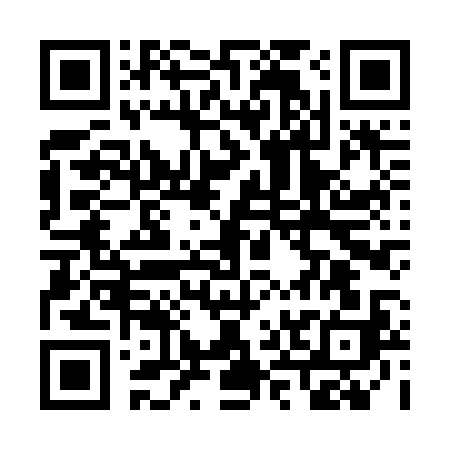

In [38]:
#@title Create a QR code from Gradio Share URL

import qrcode

# create a QR code instance with the share URL
qr = qrcode.QRCode(version=1, error_correction=qrcode.constants.ERROR_CORRECT_H)
qr.add_data(share_url)

# generate the QR code image
img = qr.make_image(fill_color="black", back_color="white")

img

### Sources

---
* Lewis, P., Perez, E., Piktus, A., Petroni, F., Karpukhin, V., Goyal, N., Küttler, H., Lewis, M., Yih, W., Rocktäschel, T., Riedel, S., & Kiela, D. (2021). *Retrieval-Augmented Generation for Knowledge-Intensive NLP Tasks* ([arXiv:2005.11401](http://arxiv.org/abs/2005.11401)). arXiv.

* Model [*all-MiniLM-L6-v2*](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2): Maps sentences & paragraphs to a 384 dimensional dense vector space and can be used for tasks like clustering or semantic search.

* Reimers, N., & Gurevych, I. (2019). *Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks* ([arXiv:1908.10084](http://arxiv.org/abs/1908.10084)). arXiv.

* [A comparison of sentence transformer pretrained_models](https://www.sbert.net/docs/sentence_transformer/pretrained_models.html#original-models)

* Wang, W., Wei, F., Dong, L., Bao, H., Yang, N., & Zhou, M. (2020). *MiniLM: Deep Self-Attention Distillation for Task-Agnostic Compression of Pre-Trained Transformers* ([arXiv:2002.10957](http://arxiv.org/abs/2002.10957)). arXiv.

* [Chroma](https://python.langchain.com/v0.2/docs/integrations/vectorstores/chroma/): an AI-native open-source vector database licensed under Apache 2.0 focused on developer productivity and happiness.

* [Meta Llama3 on Groq](https://huggingface.co/meta-llama/Meta-Llama-3-8B-Instruct) and [Llama 3 from Ollama](https://ollama.com/library/llama3): The most capable openly available LLM to date.

* [LangChain Use Cases - Q&A with RAG](https://python.langchain.com/v0.1/docs/use_cases/question_answering/)

* [Galileo: AI chatbot assistant for University of Padova](https://github.com/sinadalvand/Galileo.git)
* [LangChain in Chains #22: Chain of Thought Prompting](https://ai.plainenglish.io/langchain-in-chains-22-chain-of-thought-prompting-8b0dc4b01215)


---

<center><img src="https://fuoridalcoro.altervista.org/wp-content/uploads/2023/11/UNINA-800-LOGO_segnaposto-eventi_620x300.jpg" alt="UNINA Logo 800 Years">

---